# Fast Fourier Transform

**Jack Haek**

---

## What is the Fast Fourier Transform Algorithm

The Fast Fourier Transform Algorithm (FFT) is possibly one of the most important and elegant algorithms ever produced. The effects of this algorithm stretch to many industries including, but not limited to medical imaging, telecommunications, electromagnetic wave and quantum mechanics, as well as nearly anything to do with signal processing. For the demo today, we will see the algorithm identify what composition of sin waves is used to create a more complex wave.

**Discrete Fourier Transform (DFT)**

With regards to real world applications, the Fourier Transform is not always super helpful as functional forms of signals are not all that common. Thus, the Discrete Fourier Transform (DFT) was roughly derived from the FT.


**FT**
$$
f(k) = \int_{-\infty}^{\infty}f(x)e^{-2\pi ikx}dx
$$

**DFT**
$$
f_k=\sum_{0}^{N-1}x_ne^{\frac{-2\pi ikn}{N}}
$$



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from scipy.fft import fft, fftfreq, fftshift

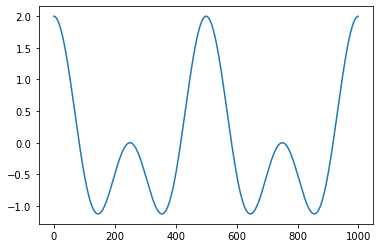

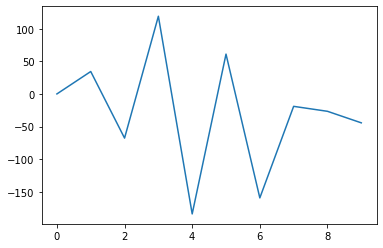

In [60]:
RES = 1000
DUR = 1

def createWave(duration, resolution, frequency):
    t = np.arange(0, duration, duration/resolution)
    return pow(np.e, 2 * np.pi * 1j * frequency * t)

def split(points):
    idx = 0
    p_e = []
    p_o = []
    for point in points:
        if idx % 2 == 0:
            # Even index
            p_e.append(point)
        else:
            # Odd index
            p_o.append(point)
        idx += 1
    return (p_e, p_o)


def my_FFT(P):
    n = len(P)
    if n == 1:
        return P
    omega = pow(np.e, (2*np.pi*1j)/n)
    pe, po = split(P)
    ye, yo = my_FFT(pe), my_FFT(po)
    y = [0] * n
    for j in range(n//2):
        y[j] = ye[j]+(pow(omega, j)*yo[j])
        y[j + n//2] = ye[j] - (pow(omega, j)*yo[j])
    return np.abs(y)                       

complex_wave = createWave(DUR, RES, 2) + createWave(DUR, RES, 4)
plt.plot(complex_wave)
plt.show()

plt.plot(my_FFT(complex_wave)[0:10])
plt.show()


In [61]:
# Testing

test_cases = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000]
custom_avg_times = []

for index, test in enumerate(test_cases):
    RES = test
    DUR = 1
    complex_wave = createWave(DUR, RES, 2) + createWave(DUR, RES, 4)
    individual_times = []
    for i in range(5):
        print(f"Starting test {i+1} for test case {index + 1}")
        start = time.time()
        freq_wave = my_FFT(complex_wave)
        end = time.time()
        individual_times.append(end-start)
    print("\n")
    custom_avg_times.append(np.average(individual_times))

Starting test 1 for test case 1
Starting test 2 for test case 1
Starting test 3 for test case 1
Starting test 4 for test case 1
Starting test 5 for test case 1


Starting test 1 for test case 2
Starting test 2 for test case 2
Starting test 3 for test case 2
Starting test 4 for test case 2
Starting test 5 for test case 2


Starting test 1 for test case 3
Starting test 2 for test case 3
Starting test 3 for test case 3
Starting test 4 for test case 3
Starting test 5 for test case 3


Starting test 1 for test case 4
Starting test 2 for test case 4
Starting test 3 for test case 4
Starting test 4 for test case 4
Starting test 5 for test case 4


Starting test 1 for test case 5
Starting test 2 for test case 5
Starting test 3 for test case 5
Starting test 4 for test case 5
Starting test 5 for test case 5


Starting test 1 for test case 6
Starting test 2 for test case 6
Starting test 3 for test case 6
Starting test 4 for test case 6
Starting test 5 for test case 6


Starting test 1 for test cas

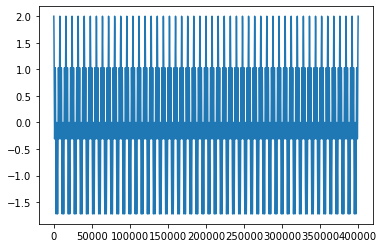

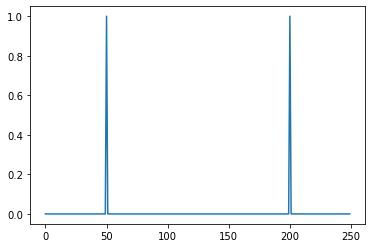

In [62]:
def scipy_fft(wave_in, N, T):
    yf = fft(wave_in)
    xf = fftfreq(N, T)
    xf = fftshift(xf)
    yplot = fftshift(yf)
    half = len(xf)//2
    return (xf[half:half+250], 1.0/N * np.abs(yplot[half:half+250]))

complex_wave = createWave(DUR, RES, 50) + createWave(DUR, RES, 200)
plt.plot(complex_wave)
plt.show()
freq = scipy_fft(complex_wave, RES, DUR/RES)

plt.plot(freq[0], freq[1])
plt.show()

In [63]:
scipy_avg_times = []

for index, test in enumerate(test_cases):
    RES = test
    DUR = 1
    complex_wave =  createWave(DUR, RES, 2) + createWave(DUR, RES, 4)
    individual_times = []
    for i in range(5):
        print(f"Starting test {i+1} for test case {index + 1}")
        start = time.time()
        freq = scipy_fft(complex_wave, RES, DUR/RES)
        end = time.time()
        individual_times.append(end-start)
    print("\n")
    scipy_avg_times.append(np.average(individual_times))

Starting test 1 for test case 1
Starting test 2 for test case 1
Starting test 3 for test case 1
Starting test 4 for test case 1
Starting test 5 for test case 1


Starting test 1 for test case 2
Starting test 2 for test case 2
Starting test 3 for test case 2
Starting test 4 for test case 2
Starting test 5 for test case 2


Starting test 1 for test case 3
Starting test 2 for test case 3
Starting test 3 for test case 3
Starting test 4 for test case 3
Starting test 5 for test case 3


Starting test 1 for test case 4
Starting test 2 for test case 4
Starting test 3 for test case 4
Starting test 4 for test case 4
Starting test 5 for test case 4


Starting test 1 for test case 5
Starting test 2 for test case 5
Starting test 3 for test case 5
Starting test 4 for test case 5
Starting test 5 for test case 5


Starting test 1 for test case 6
Starting test 2 for test case 6
Starting test 3 for test case 6
Starting test 4 for test case 6
Starting test 5 for test case 6


Starting test 1 for test cas

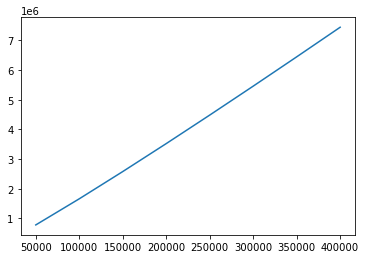

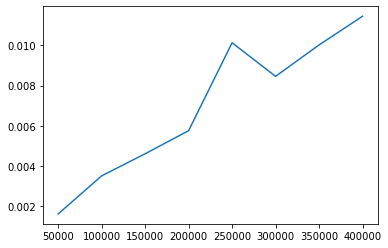

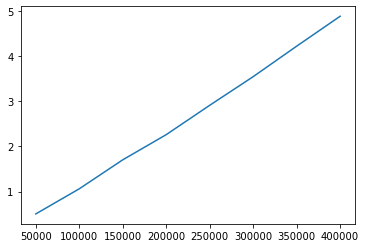

In [64]:
plt.plot(test_cases, test_cases*np.log2(test_cases)-15)
plt.show()
plt.plot(test_cases, scipy_avg_times)
plt.show()
plt.plot(test_cases, custom_avg_times)
plt.show()